### Analyzing Spike Recordings
#### Methods from Tong-Wey
- The amplifier's high pass filter is set at 10 Hz and low pass filter at 3 kHz.
- Nerve cell recordings from  were acquired at 10kHz. 
- The raw spikes were recorded in a .abf format on Clampex 10.4 by Molecular Devices. The files have be converted into a .atf format, which can be opened with Microsoft Excel. 

#### Initialize variables

In [1]:
!date
datadir = '/Users/jacuzzijo/Google Drive/ACC Lab/ACR/Larval nerve ephys/data/30s_pulse/'
atfdir = datadir+'atf/raw/'
# Sample rate. MUST BE SAME ACROSS ALL NERVE RECORDINGS.
fs = 10000.0       

# Here we implement Tracey et al. 2003 bandpass settings.
lowcut = 100.0     # discard frequencies lower than this.
highcut = 1500.0   # discard frequencies higher than this.
order = 5         # order of the Butterworth filter (not exactly sure what this means, 
                   # but the higher the order, the "tighter" the cutoff.
lightCol = 'lightgreen' # color of light pulse, for plotting on spike plots and raster plots.
dpi = 250 # dpi of figures.

# Define the datetimes and timedeltas here.
import datetime 
starttime = datetime.datetime(2016, 7, 1, 0, 0, 3, 156100) # Assigns arbitrary date for easy parsing.
#### READ THIS FROM TONG-WEY'S SPREADSHEET; NOT IMPLEMENTED YET! ####
# 0.1561 seconds = 156100 microseconds.
pulse = datetime.timedelta(milliseconds = 500)
pulseInterval = datetime.timedelta(seconds = 2)

Thu Oct 13 14:23:42 SGT 2016


#### Load Libraries and Custom Commands

In [2]:
import seaborn as sb
import pandas as pd
import numpy as np
import os
from numpy import fft
from scipy import signal
import quickspikes as qs
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import bootstrapContrast as bs
#%matplotlib inline
sb.set_style('ticks')
plt.rcParams['svg.fonttype'] = 'none' # Ensures the text in figures are not lines but text.
mpl.rcParams['agg.path.chunksize'] = 10000 
# Mitigates this error: https://github.com/matplotlib/matplotlib/issues/5907

def convert_time(a):
    sec = int(a) # get the second
    temp_us = round(a, 6) # round to 6 decimal places.
    us = str(a).split(".")[-1]
    mult = 6 - len(us)
    # extract the numbers after the decimal place. 
    # we need to add enough zeros so that we get
    # microseconds (1 millionth of a second).
    return datetime.datetime(2016, 7, 1, 0, 0, sec, int(us)*(10**mult))

def stateChange(data):
    import numpy as np
    '''Get points where light turned on/off.'''
    return np.split(data, np.where(np.diff(data) > stepsize)[0]+1)

def butter_bandpass(lowcut, highcut, fs, order=5):
    '''Bandpass filter. Taken from http://scipy.github.io/old-wiki/pages/Cookbook/ButterworthBandpass'''
    from scipy.signal import butter
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band', analog=False)
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    '''Applies custom Butterworth bandpass filter to timeseries.'''
    from scipy.signal import lfilter
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

def plotSpectrum(y, Fs, ax):
    """ Plots a Single-Sided Amplitude Spectrum of y(t)
    Modified from: http://glowingpython.blogspot.sg/2011/08/how-to-plot-frequency-spectrum-with.html """
    import numpy as np
    from numpy import fft
    n = len(y) # length of the signal
    k = np.arange(n)
    T = n/Fs
    frq = k/T # two sides frequency range
    frq = frq[ np.arange( int(n/2) ) ] # one side frequency range

    Y = fft.fft(y)/n # fft computing and normalization
    Y = Y[ np.arange( int(n/2) ) ]

    ax.plot(frq, abs(Y),'r') # plotting the spectrum
    ax.set_xlabel('Freq (Hz)', fontsize = 12)
    ax.set_ylabel('|Y(freq)|', fontsize = 12)

def plotSpectrogram(y, Fs, ax, colmap = 'plasma', ylim = (0,2000)):
    """ Plots a Spectrogram of `y`, given the sampling frequency `fs`.
    Modified from: http://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.spectrogram.html """
    from scipy import signal
    import matplotlib.pyplot as plt
    cmap = plt.get_cmap(colmap)            # For more colormaps, see 
                                           # http://matplotlib.org/examples/color/colormaps_reference.html
    # (y,x,z) of spectrogram
    f, t, Sxx = signal.spectrogram(y, Fs)
    ax.pcolormesh(t, f, Sxx, cmap = cmap, axes = ax)
    ax.set_ylim(ylim)
    ax.set_ylabel('Frequency [Hz]', fontsize = 12)
    ax.set_xlabel('Time [sec]', fontsize = 12)
    
def to_seconds(t, pos):
    '''Converts 10kHz timestamp into seconds.'''
    sec = str(t/10000)
    return sec

# I need to give the timeseries itself AND the lighton protocol.
def bandpassFilter(series, 
                   plot = False,
                   fname = 'bandpassFilter', 
                   titlefs = 15,
                   fs = 10000.,
                   lowcut = 100.,
                   highcut = 2000.,
                   order = 5,   
                   plotsize = (18, 12)):
    '''Takes a pandas Series and bandpass filters it with a Butterworth filter.
    It can produce two things: a pandas Series of the bandpass filtered data, 
    and a before-and-after plot with a frequency spectrum and spectrogram (if plot = True).
    '''
    import matplotlib.pyplot as plt
    from matplotlib.ticker import FuncFormatter
    secFmt = FuncFormatter(to_seconds)
    
    # Parse the lighton series. Get the indexes where LED > 0.
    # Use these indexes later to 'color in' the illumination epochs.
    
    # Bandpass filter raw trace according to Tracey et al. 2003 settings: 100Hz – 2kHz.
    # Keep a pandas DataFrame version and a np.array version.
    # This is because you cannot pipe a pandas DataFrame to the spike detector.
    bandpass_orig = butter_bandpass_filter(series, lowcut, highcut, fs, order)
    bandpass = pd.Series( bandpass_orig )
    bandpass.index = series.index # Set index of bandpass trace.
    
    # Create figure. 
    fig, axarr = plt.subplots(nrows = 3, ncols = 2, figsize = plotsize)
    
    if plot is True:
        # Plot the raw trace.
        series.plot( ax = axarr[0,0], figsize = plotsize, color = 'k' )
        axarr[0,0].set_title( fname + " Raw Trace", fontsize = titlefs )
        axarr[0,0].yaxis.set_major_formatter(secFmt) # Make sure the x-axis is in seconds.
        axarr[0,0].set_ylabel('mV', fontsize = 12)
        axarr[0,0].set_ylabel('Time [sec]', fontsize = 12)

        # Plot spectrogram of raw trace.
        plotSpectrogram( y = series, Fs = fs, ax = axarr[1,0])
        axarr[1,0].set_title( fname + " Raw Spectrogram", fontsize = titlefs )

        # Plot frequency spectrum of raw trace.
        plotSpectrum( y = series, Fs = fs, ax = axarr[2,0] )
        axarr[2,0].set_title( fname + " Raw Frequency Spectrum", fontsize = titlefs )

        # Plot the bandpass trace.
        bandpass.plot( ax = axarr[0,1], figsize = plotsize, color = 'k' )
        axarr[0,1].set_title( fname + " Bandpass Trace " + str(lowcut) + "Hz–" + str(highcut) + "Hz", 
                             fontsize = titlefs )
        axarr[0,1].yaxis.set_major_formatter(secFmt)
        axarr[0,1].set_ylabel('mV')

        # Plot spectrogram of bandpass trace.
        plotSpectrogram( y = bandpass, Fs = fs, ax = axarr[1,1])
        axarr[1,1].set_title( fname + " Bandpass Spectrogram", fontsize = titlefs )

        # Plot frequency spectrum of bandpass trace.
        plotSpectrum( y = bandpass, Fs = fs, ax = axarr[2,1] )
        axarr[2,1].set_title( fname + " Bandpass Frequency Spectrum", fontsize = titlefs )

        # Aesthetic tweaks
        for arr in axarr:
            for a in arr:
                sb.despine(ax = a)
        fig.tight_layout()
        return fig, bandpass_orig
    
    else: # If we are not plotting anything.
        return bandpass_orig

In [3]:
# # Read in led protocols. 
# # These protocol files are large (>10MB) and will take about 30sec each to read in.
# # Instead I will load the pickled datasets. If these change, rerun the lines below.
# led1pro = pd.read_excel('/Users/josesho/Google Drive/ACC Lab/ACR/Larval nerve ephys/data/500ms_pulse/LED1 protocol.xlsx',
#                        index_col = 'Time (s)')
# led30pro = pd.read_excel('/Users/josesho/Google Drive/ACC Lab/ACR/Larval nerve ephys/data/30s_pulse/LED 30s protocol.xlsx',
#                        index_col = 'Time (s)')

# # Read in experiment info.
# exptInfo = pd.read_excel('/Users/josesho/Google Drive/ACC Lab/ACR/Larval nerve ephys/Expt Info Spreadsheets/Expt Info Ephys GtACR1 all data.xlsx')

# # Pickle the data.
# led1pro.to_pickle('/Users/josesho/Google Drive/ACC Lab/ACR/Larval nerve ephys/Expt Info Spreadsheets/led1pro.pickle')
# led30pro.to_pickle('/Users/josesho/Google Drive/ACC Lab/ACR/Larval nerve ephys/Expt Info Spreadsheets/led30pro.pickle')
# exptInfo.to_pickle('/Users/josesho/Google Drive/ACC Lab/ACR/Larval nerve ephys/Expt Info Spreadsheets/exptInfo.pickle')

# Read in pickled data. Very fast.
led1pro = pd.read_pickle('/Users/jacuzzijo/Google Drive/ACC Lab/ACR/Larval nerve ephys/Expt Info Spreadsheets/led1pro.pickle')
led30pro = pd.read_pickle('/Users/jacuzzijo/Google Drive/ACC Lab/ACR/Larval nerve ephys/Expt Info Spreadsheets/led30pro.pickle')
exptInfo = pd.read_pickle('/Users/jacuzzijo/Google Drive/ACC Lab/ACR/Larval nerve ephys/Expt Info Spreadsheets/exptInfo.pickle')

# Identify light change indexes, add into a dictionary.
lightChangeProtocols = {'LED1' : np.where(np.diff(led1pro['LED1']) != 0)[0]+1,
                        'LED 30s' : np.where(np.diff(led30pro['LED 30s']) != 0)[0]+1
                       }

In [ ]:
# This cell will read all the raw ATF files and bandpass filter them.
# All the bandpass filtered signals are stored in binary .npy format.
# If you have already done this, do not run this cell unless you want to change the bandpass settings.

# Basic variables to initialise.
makePlot = True # if we want to produce a plot. If we don't and only want the bandpass filtered signal, set to False.
fileformat = 'png'

for subdir, dirs, files in os.walk(atfdir): # loop thru the subdirectories in the ATF_files folder. 
    for file in files:
        if (len(file.split('.')) > 1) and (file.split('.')[1] == 'atf'):
            # if and only if the file extension is `.atf`...
            fname = os.path.join(subdir, file) # pathname of .atf file to read in.
            dfname = file.split('.')[0]        # dfname to print in plots.
            df = pd.read_csv(fname,
                 sep='\t',
                 skiprows = range(0,10),       # Skips the first 10 rows.
                 index_col = 'Time (s)'
                ) 
            # Get the relevant row from experiment info for reference and details. 
            tempExptInfo = exptInfo[ exptInfo['Filename'] == int(dfname) ]
            # Get illumination distance.
            illumDist = str(tempExptInfo.iloc[0]['Illumination_mm'])
            # Get Genotype_LarvaID_abdominal segment
            genoLarvaID = tempExptInfo.iloc[0]['Genotype_Larva']
            abSeg = str(tempExptInfo.iloc[0]['Abdominal segment'])
            # Get light epoch from exptInfo.
            protocol = tempExptInfo.iloc[0]['Protocol']

            # Get light epochs from exptInfo.
            lightChangeIdx = lightChangeProtocols[ protocol ]

            for ix, c in enumerate(df.columns):
                # Parse trace title.
                name = dfname + '_' + df.columns[ix]
                # Make a nice title for entire figure.
                title = name + "_" + protocol + "_" + illumDist + "mm_" + genoLarvaID + "_" + abSeg
                
                # obtain bandpass filtered trace and plot basic frequency spectrum and spectrogram if so desired.
                if makePlot is True:
                    figTrace, bp = bandpassFilter(df[c], # the timeseries
                                                  plot = makePlot,
                                                  fname = name,       
                                                  fs = fs,
                                                  lowcut = lowcut,
                                                  highcut = highcut,
                                                  order = order
                                                  )
                    # for each lightEpoch, color in the raw traces (axes 0 and 1, the top-row plots.)
                    for ax in [0,1]:
                        for idx in np.arange(0, len(lightChangeIdx), 2):
                            figTrace.get_axes()[ax].axvspan(xmin = lightChangeIdx[idx]/fs, 
                                                            xmax = lightChangeIdx[idx+1]/fs, 
                                                            ymin = -1, 
                                                            ymax = 1, 
                                                            alpha = 0.2, 
                                                            color = 'grey')
                    # Add the title to the _bottom_ of the plot.
                    figTrace.suptitle(title, x = 0.5, y = 0.015, fontsize = 15)
                    # Save the figure.
                    figTrace.savefig(datadir + "/bandpassPlots/" + title + '.' + fileformat, format = fileformat, dpi = dpi)
                    # closes the figure to save memory.
                    plt.close(figTrace)

                else: # if we only want the bandpass filtered trace.
                    bp = bandpassFilter(df[c], 
                                        plot = makePlot,
                                        fname = name,    
                                        fs = fs,
                                        lowcut = lowcut,
                                        highcut = highcut,
                                        order = order
                                       )
                    
                # Save mean and std of bandpass signal for later spike detection.
                bp_mean = bp.mean()
                bp_std = bp.std()
                # Save bandpass filtered trace as .npy
                np.save(datadir + "/atf/bandpass_filtered/" + title + '_bandpassFiltered_' + str(int(lowcut)) + '-' + str(int(highcut)) + 'Hz.npy',
                       bp)
                # if processing jammed up, we can identify the file.
                print(fname)

In [ ]:
# This cell will read stored bandpass signals and run spike detection on them.
# All the bandpass filtered signals are stored in binary .npy format.
# The detected spike IDs (indices corresponding to the index of the corresponding raw ATF file) are stored as .npy format.
# If you have already done this, do not run UNLESS you want to tweak the spike detection settings. 

# The spike detector settings.
threshold = 1.96 # This is the scaled threshold, in SD of the signal. A spike must cross this threshold to count.
window = 500    # A spike cannot be longer than this window. Default of 500 will look for signals below 200Hz. 

print("Spike detection settings:")
print("Scaled Threshold (in SD) =", threshold)
print("Window Size =", window)

bpdir = datadir + "/atf/bandpass_filtered/"
for subdir, dirs, files in os.walk(bpdir): # loop thru the subdirectories in the folder with the bandpass filtered data. 
    for file in files:
        if (len(file.split('.')) > 1) and (file.split('.')[1] == 'npy'):
            # if and only if the file extension is `.npy`...
            signalname = file.split('.')[0]
            atfname = file.split('_')[0]
            signal = np.load(bpdir+file) # Read in the pickled bandpass signal.
            
            # Perform spike detection ACROSS ENTIRE BANDPASS SIGNAL.
            # For more info see https://github.com/melizalab/quickspikes
            d = qs.detector(threshold, window)
            d.scale_thresh(np.mean(signal), np.std(signal))
            spikes_idx = d.send(signal)
            
            # Turn the list generated into a numpy array.
            spikes_idx = np.array(spikes_idx)
            # Create filename.
            signalname = signalname + "_spikes--WindowSize" + str(window) + "--ScaledThresholdSD" + str(threshold)
            # Save as binary .npy format. 
            np.save(datadir+'threshold_'+str(threshold)+'_SD/spikes/npy_files/'+signalname+".npy", spikes_idx)
            # to see where (if) the code gums up.
            print(signalname)

In [ ]:
# This cell will read all spike IDs and create spike-rug plots for each bandpass filtered trace.
# It will create spike-rug plots for each trace as well.
# All the spike IDs are stored in binary .npy format.
# Line below turns off interactive mode for matplotlib.
# See http://matplotlib.org/faq/usage_faq.html#non-interactive-example 
plt.ioff()
# Load patches for plotting light on pulses.
import matplotlib.patches as patches

# Define the correct directories.
threshold = 1.96 # This is the scaled threshold, in SD of the signal.
                 # Change as appropriate for plotting and analysis.
bpdir = datadir + "atf/bandpass_filtered/"
spikedir = datadir + 'threshold_'+str(threshold)+'_SD/spikes/npy_files/'

# In prep to make sure the x-axis is properly formatted.
secFmt = FuncFormatter(to_seconds)

# Define the before and after padding, in terms of multiples of the light pulse.
# For 500ms we set this as twice the pulse length, i.e. 1s.
# This CANNOT be less than 0.
beforePad = 2 
afterPad = 2

for subdir, dirs, files in os.walk(spikedir):
    for file in files:
        if (len(file.split('.')) > 1) and (file.split('.')[-1] == 'npy'):
            # If and only if the file extension is `.npy`...
            # Read in the correct bandpass signal.
            bandpassFilename = bpdir + file.split('_spikes')[0] +'.npy'
            print(file)
            bandpass = pd.Series(np.load(bandpassFilename)) # make sure is a pandas Series.
            # Read in the spike indicies.
            spike_idx = np.load(spikedir+file)
            
            # Read in the correct protocol from the filename.
            protocol = file.split('_')[2]
            # Get light epochs from exptInfo.
            lightChangeIdx = lightChangeProtocols[ protocol ]
            
            # Make spike-rug plot for entire trace.
            figSpikeRug, axx = plt.subplots(1, figsize = (15,7))
            pd.Series(bandpass).plot( ax = axx, color = 'k' )

            for spike in spike_idx:
                axx.axvline(x = spike, 
                            ymax = 0.05, # the height of the rugtick will be this fraction of the plot.
                            color = 'k', 
                            linewidth = 0.5,
                            alpha = 0.5)

            # Prepare y-axis for plotting of lightOn pulse rectangles.
            # First, get the tick interval.
            tickInt = axx.yaxis.get_ticklocs()[1] - axx.yaxis.get_ticklocs()[0]
            # Then, get the current view interval.
            minY, maxY = axx.yaxis.get_view_interval()
            # Make sure, after adjustment, the y-axis is symmetrical about zero.
            halfY = max([minY - tickInt, maxY + tickInt])
            axx.yaxis.set_view_interval(-halfY, halfY)
            
            # Draw red line to indicate mean
            axx.axhline(y = np.mean(bandpass), lw = 0.5, color = 'red')
            # Draw red line to indicate the spike threshold.
            # Threshold should have been defined in cell above; double-check with filename...
            axx.axhline(y = threshold * np.std(bandpass), lw = 0.5, color = 'red')

            # Aesthetic tweaks.
            axx.set_ylabel('mV', fontsize = 12)
            axx.set_xlabel('Time [sec]', fontsize = 12)
            axx.set_title(file, fontsize = 9)
            # Make sure the x-axis is in seconds.
            axx.xaxis.set_major_formatter(secFmt)
            
#             # Loop thru each light pulse and make each light pulse its own spikerug plot.
#             for n, idx in enumerate(np.arange(0, len(lightChangeIdx), 2)):
#                 pulseNum = str(n+1)
#                 # For each pulse, extract the pulse length
#                 pulseLengthIdx = lightChangeIdx[idx+1] - lightChangeIdx[idx]
#                 pulseLengthSec = pulseLengthIdx/fs
                
#                 # Draw the rectangle for this pulse.
#                 axx.add_patch(
#                     patches.Rectangle(
#                         ( lightChangeIdx[idx], maxY ),   # xy coords of left most corner of rect
#                         pulseLengthIdx,       # width of rect.
#                         tickInt/5,            # height of rect
#                         color = lightCol
#                         )
#                     )
                
#                 # Zoom in and save the figure.
#                 axx.set_xlim( lightChangeIdx[idx] - (pulseLengthIdx*beforePad),
#                              lightChangeIdx[idx+1] + (pulseLengthIdx*afterPad) )
#                 sb.despine(ax = axx)
#                 for f in ['svg', 'png']:
#                     figSpikeRug.savefig(datadir + 'threshold_'+str(threshold)+'_SD/spikes/plots/pulses/'+file+'_pulseNum'+pulseNum+'.'+f,
#                                        format = f, dpi = dpi)
            
            # Now, reset the view interval, and save the entire span of the spikerug plot.
            axx.set_xlim( 0, len(bandpass) )
            for f in ['svg', 'png']:
                figSpikeRug.savefig(datadir + 'threshold_'+str(threshold)+'_SD/spikes/plots/wholeTrace/'+file+'.'+f,
                                   format = f, dpi = dpi)
            plt.close(figSpikeRug)

In [33]:
# This cell will read all spikeIDs and create a dataframe for contrast plots, 
# and another one for raster plots.
spikeList = list()
rasterList = list()

# Define the before and after padding, in terms of multiples of the light pulse.
# This CANNOT be less than 0.
beforePad = 1
afterPad = 1

# Define the correct directories.
threshold = 2.58 # This is the scaled threshold, in SD of the signal.
                 # Change as appropriate for plotting and analysis.
spikedir = datadir + 'threshold_'+str(threshold)+'_SD/spikes/npy_files/'

for subdir, dirs, files in os.walk(spikedir):
    for file in files:
        if (len(file.split('.')) > 1) and (file.split('.')[-1] == 'npy'):
            # If and only if the file extension is `.npy`...
            # Read in the file.
            spike_idx = np.load(spikedir+file)
            # Get the ATF filename and the trace number.
            atfname = file.split('_')[0]
            trace = file.split('_')[1]
            # Get bandpass filter info and spike detection info.
            allInfo = file.split('_bandpass')[-1].split('.')[0]
            # Get the relevant row from experiment info for reference and details. 
            tempExptInfo = exptInfo[ exptInfo['Filename'] == int(atfname) ]

            # Read in the correct protocol from the filename.
            protocol = file.split('_')[2]
            # Get light epochs from exptInfo.
            lightChangeIdx = lightChangeProtocols[ protocol ]
            
            # Cycle thru each light pulse and collect the spikes that fall 
            # before, during, and after each epoch.
            for n, idx in enumerate(np.arange(0, len(lightChangeIdx))):
                if idx+1 != len(lightChangeIdx):
                    pulseNum = str(n+1)
                    # For each pulse, extract the pulse length
                    pulseLengthIdx = lightChangeIdx[idx+1] - lightChangeIdx[idx] - 1 # not sure why have to subtract one.
                    pulseLengthSec = pulseLengthIdx/fs

                    # define a rasterEpoch, which spans from start of before to end of after.
                    rasterEpoch = spike_idx[ (spike_idx >= lightChangeIdx[idx] - (pulseLengthIdx*beforePad*(1/2)) ) & 
                                            (spike_idx < lightChangeIdx[idx+1]  + (pulseLengthIdx*afterPad*(1/2)) ) ]

                    # shift rasterEpoch so that 0 is the start of the window, for all pulses.
    #                 rasterEpoch = rasterEpoch - lightChangeIdx[idx]
                    if len(rasterEpoch) > 0:
                        rasterEpoch = rasterEpoch - int( lightChangeIdx[0] - (pulseLengthIdx*beforePad*(1/2)) )
                    # Save into pandas dataframe.
                    rasters = pd.Series( { 'traceName': atfname,
                                          'traceNum': trace,
                                          'pulseNum' : str(n+1),
                                          'illumination_mm': tempExptInfo.iloc[0]["Illumination_mm"],

                                          'spikeIndices' : rasterEpoch,
                                          'spikeCount': len(rasterEpoch),

                                          'genotype': tempExptInfo.iloc[0]["Genotype"],
                                          'larva': tempExptInfo.iloc[0]["Larva"],
                                          'nerve': tempExptInfo.iloc[0]["Nerve"],
                                          'abdominalSegment': tempExptInfo.iloc[0]["Abdominal segment"],
                                          'sampleRate' : fs,
                                          'pulseLengthSec' : pulseLengthSec,
                                          'pulseStartIdx' : 0,
                                          'pulseEndIdx' : pulseLengthIdx,
                                          'illuminationProtocol' : tempExptInfo.iloc[0]["Protocol"],

                                          'processingSettings': allInfo
                                           } )
                    rasterList.append(rasters)

                    # Define the before, during, and after epochs.
                    bef = spike_idx[ (spike_idx >= lightChangeIdx[idx] - (pulseLengthIdx*beforePad)) & 
                                       (spike_idx < lightChangeIdx[idx]) ]
                    dur = spike_idx[ (spike_idx >= lightChangeIdx[idx]) & 
                                       (spike_idx < lightChangeIdx[idx+1]) ]
                    aft = spike_idx[ (spike_idx >= lightChangeIdx[idx+1]) & 
                                       (spike_idx < lightChangeIdx[idx+1]  + (pulseLengthIdx*afterPad)) ]
                    epochs = {'before': bef,
                              'during': dur,
                              'after': aft}
                    # Loop thru the epochs and compute the spike count and spike frequency.
                    for epoch in epochs.keys():
                        spikes = pd.Series( { 'traceName': atfname,
                                             'traceNum': trace,
                                             'pulseNum' : str(n+1),
                                             'epoch': epoch,
                                             'illumination_mm': tempExptInfo.iloc[0]["Illumination_mm"],

                                             'spikeIndices' : epochs[epoch],
                                             'spikeCount': len(epochs[epoch]),

                                             'genotype': tempExptInfo.iloc[0]["Genotype"],
                                             'larva': tempExptInfo.iloc[0]["Larva"],
                                             'nerve': tempExptInfo.iloc[0]["Nerve"],
                                             'abdominalSegment': tempExptInfo.iloc[0]["Abdominal segment"],
                                             'pulseLength' : pulseLengthSec,
                                             'illuminationProtocol' : tempExptInfo.iloc[0]["Protocol"],

                                             'processingSettings': allInfo
                                           } )
                        spikeList.append(spikes)

rasterList = pd.DataFrame(rasterList)
rasterList['tickLabel'] = rasterList['traceName'] + " " + rasterList['genotype'] + " " + rasterList['traceNum'] + " " + rasterList['pulseNum'] + " " + rasterList['illumination_mm'].astype(str) + 'mm'
# Create parental status column.
rasterList['status'] = np.where(rasterList['genotype'] == 'nSyb-Gal4>UAS-dGtACR1', 
                                'offspring', 'parent')
rasterList.to_csv(datadir + 'threshold_'+str(threshold)+'_SD/rasters_'+str(threshold)+'_SD.csv')
rasterList.to_pickle(datadir + 'threshold_'+str(threshold)+'_SD/rasters_'+str(threshold)+'_SD.pickle')

spikeList = pd.DataFrame(spikeList)
spikeList['spikeFrequency (Hz)'] = spikeList['spikeCount'] / spikeList['pulseLength']
spikeList.to_csv(datadir + 'threshold_'+str(threshold)+'_SD/spikeCounts_'+str(threshold)+'_SD.csv')
spikeList.to_pickle(datadir + 'threshold_'+str(threshold)+'_SD/spikeCounts_'+str(threshold)+'_SD.pickle')

In [26]:
# Input in this cell all the indices (from the figures above) that you want to remove from analysis.
# We are focussing on threshold SD = 1.96 first.
dropList = [33, 39, 40, 42, 48, 49, 50 # Mutants
           ]

In [38]:
# This cell will read the spike counts, and create stacked and summed raster plots.
# The spike counts are stored in pickle format.
# Line below turns off interactive mode for matplotlib.
# See http://matplotlib.org/faq/usage_faq.html#non-interactive-example 
plt.ioff()
fsize = (20,20)
stackRasterRowSpan = 15 
summedRasterRowSpan = 5 # These two variables should add up to fsize[0].

# Define the correct directories.
threshold = 2.58 # This is the scaled threshold, in SD of the signal.
                 # Change as appropriate for plotting and analysis.
workdir = datadir + 'threshold_'+str(threshold)+'_SD/'
writedir = datadir + 'threshold_'+str(threshold)+'_SD/rasters/'

secFmt = FuncFormatter(to_seconds) # to format the x-axis of the spike zoom ins

# Read in the pickle. 
# Below variables are hardcoded for ease, for now.
rollingAvBinSize = 1000 # this is the window size. Multiply by fs to get this in seconds.
pulseLengthSec = 30
pulseLengthIdx = int(pulseLengthSec*fs)
maxY_Hz = 0.15
# Define the before and after padding, in terms of multiples of the light pulse.
# This CANNOT be less than 0.
beforePad = 1
afterPad = 1
rasterSpanIdx = int(pulseLengthIdx + beforePad*pulseLengthIdx*(1/2) + afterPad*pulseLengthIdx*(1/2))
rasters = pd.read_pickle(workdir+'rasters_'+str(threshold)+'_SD.pickle')
# Comment out the line below if you DO NOT want to drop any data.
rasters = rasters.drop(dropList, axis = 0)

for status in rasters['status'].unique():
    # Filter the data and sort it.
    tempdf = rasters[(rasters['status'] == status) &
                     (rasters['illumination_mm'] != 110)].sort_values( by = ['genotype',
                                                                            'illumination_mm'] 
                                                                     )
    # Calculate summed Rasters
    summedRasters = list()
    # loop thru each row of tempIdx and pull out the spike indices for each combined epoch.
    for i in tempdf.index:
        spikeIdx = tempdf.ix[i,'spikeIndices']
        # Make a temp Series, assign all values as 0.
        spikePos = pd.Series( np.repeat(0, rasterSpanIdx) )
        spikePos[spikeIdx] = 1
        # Calculate spike frequency in rolling windows.
        spikePos = spikePos.rolling(rollingAvBinSize).mean()*( 1/(rollingAvBinSize/fs) )
        # Save this Series.
        summedRasters.append(spikePos)
    # Turn the list into a nice DataFrame.
    summedRasters = pd.DataFrame(summedRasters)
    summedRasters = summedRasters.mean()
    
    # Initialize figure.
    fig = plt.figure(figsize = fsize)
    axarr = list()
    axarr.append( plt.subplot2grid(fsize,
                                   (0, 0), 
                                   rowspan = stackRasterRowSpan, 
                                   colspan = fsize[1] )
                )
    axarr.append( plt.subplot2grid(fsize,
                                   (stackRasterRowSpan, 0), 
                                   rowspan = summedRasterRowSpan, 
                                   colspan = fsize[1] )
                )

    # Calculate the height of each raster.
    ymin = 1/len(tempdf)
    # Make sure each tick location matches the number of pulses we are plotting.
    yticklocs = list()
    yindex = list()
    #yticklocs = ( np.array( range( 1, len(tempdf)+1) ) / ( len(tempdf)+1 ) )# + ymin/2
    # Loop thru each spike index and plot it.
    for i, raster in enumerate(tempdf['spikeIndices']):
        for spike in raster:
            axarr[0].axvline(x = spike,
                             linewidth = 0.5,
                             ymin = ymin * (i),     # both ymin and ymax are in terms of figure fractional height.
                             ymax = ymin * (i+1), 
                             color = 'k', 
                             alpha = 0.4)
        yindex.append(i)
        yticklocs.append((ymin * i) + ymin/2)

    # make sure the xlimit spans over all the epochs.
    axarr[0].set_xlim(0, rasterSpanIdx)
    # Set the y-tick locations.
    axarr[0].set_yticks(yticklocs)
    # Set the ytick labels and font size.
    axarr[0].set_yticklabels(tempdf['tickLabel'].index.astype(str) +'--'+ tempdf['tickLabel'],
                             fontsize = 10)
    # remove the xticklabels to reduce clutter. 
    axarr[0].set_xticklabels([]) 
    # Add title.
    axarr[0].set_title(status, fontsize = 18, fontweight = 'bold')

    # # Plot summed raster.
    summedRasters.plot( ax = axarr[1], color = 'k' )
    
    import matplotlib.patches as patches
    # indicate the LightOn pulse with a rectangle at the top of the plot.
    summedRasterMaxY = axarr[1].yaxis.get_view_interval()[1]
    axarr[1].add_patch(
        patches.Rectangle(
            ( (pulseLengthSec*beforePad*2)*fs, (maxY_Hz/20)*16),   # xy coords of leftmost corner of rect
            pulseLengthSec*fs,    # width of rect.
            maxY_Hz/20,               # height of rect.
            color = lightCol
        )
    )
    
    # Make sure the x-axis is in seconds, and label it as such.
    axarr[1].xaxis.set_major_formatter(secFmt)
    axarr[1].set_xlabel('Time (s)', fontsize = 18)
    # Make sure the y-axis of the summed raster plot starts from 0, and label it appropriately.
    axarr[1].yaxis.set_view_interval(0, maxY_Hz)
    axarr[1].set_ylabel('Average Spike Frequency (Hz)', fontsize = 18)
    # Despine all the axis.
    for a in axarr:
        sb.despine(ax = a)
    # Make sure nothing overlaps.
    fig.tight_layout()
    # Use the lines below if you DID NOT DROP any data.
#     fig.savefig(writedir+genotype+'_rasterplot.png', format = 'png', dpi = 250)
#     fig.savefig(writedir+genotype+'_rasterplot.svg', format = 'svg', dpi = 250)
    # Use the lines below if you DID drop data.
    fig.savefig(writedir+status+'_dataDrop_rasterplot.png', format = 'png', dpi = 250)
    fig.savefig(writedir+status+'_dataDrop_rasterplot.svg', format = 'svg', dpi = 250)
    plt.close(fig)

In [22]:
# This cell takes the dropped indexes of the raster plots 
# and pulls out the ATF file, trace number, pulse number, and index.

# Define the correct directories.
threshold = 2.58 # This is the scaled threshold, in SD of the signal.
                 # Change as appropriate for plotting and analysis.
workdir = datadir + 'threshold_'+str(threshold)+'_SD/'
rasters = pd.read_pickle(workdir+'rasters_'+str(threshold)+'_SD.pickle')
spikes = pd.read_pickle(datadir + 'threshold_'+str(threshold)+'_SD/spikeCounts_'+str(threshold)+'_SD.pickle')

# From dropList indices, compile new list of TraceName_Num_Pulses to drop.
dropTraceNameNumPulse = list()
for i in dropList:
    s = str(rasters.ix[i,'traceName']) + " " + str(rasters.ix[i,'traceNum']) + " " + str(rasters.ix[i, 'pulseNum'])
    dropTraceNameNumPulse.append(s)

# Loop thru `spikes` and compile indices of TraceName_Num_Pulses to drop.
dropTraceNameNumPulseIdx = list()
for i in spikes.index:
    s = str(spikes.ix[i,'traceName']) + " " + str(spikes.ix[i,'traceNum']) + " " + str(spikes.ix[i, 'pulseNum'])
    if s in dropTraceNameNumPulse:
        dropTraceNameNumPulseIdx.append(i)
        
# Drop the TraceName_Num_Pulses from `spikes`, as well as 110mm and 280mm data points.
spikes_dropped = spikes.drop(dropTraceNameNumPulseIdx, axis = 0)
spikes_dropped = spikes_dropped[(spikes_dropped['illumination_mm'] != 110) & 
                               (spikes_dropped['illumination_mm'] != 280)]
# Create new column as idcol.
spikes_dropped['traceNameNumPulse'] = spikes_dropped['traceName'].astype(str) + ' ' + spikes_dropped['traceNum'].astype(str) + ' ' + spikes_dropped['pulseNum'].astype(str)
# Create parental status column
spikes_dropped['status'] = np.where(spikes_dropped['genotype'] == 'nSyb-Gal4>UAS-dGtACR1', 
                                    'offspring', 'parent')

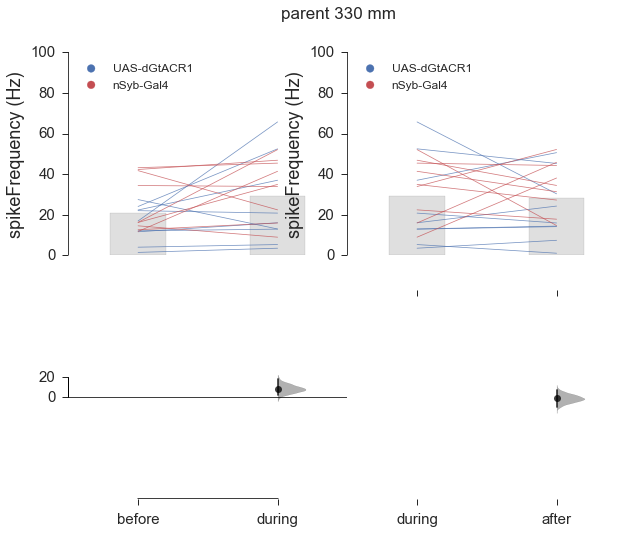

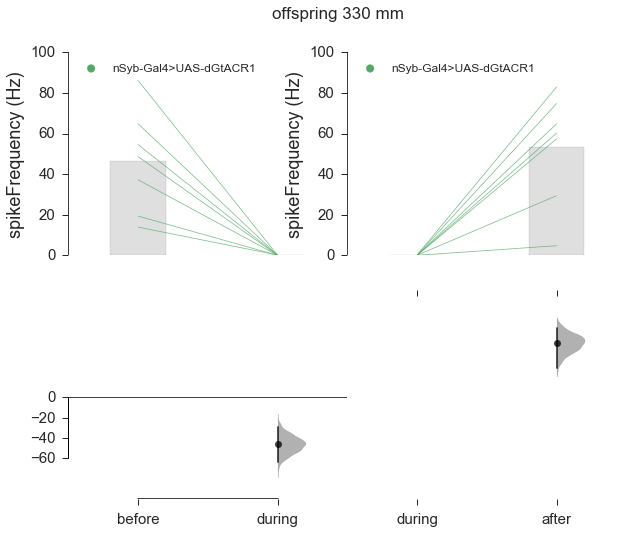

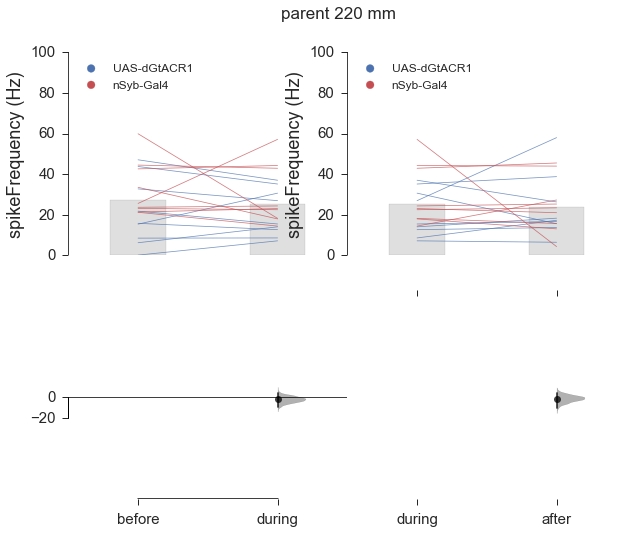

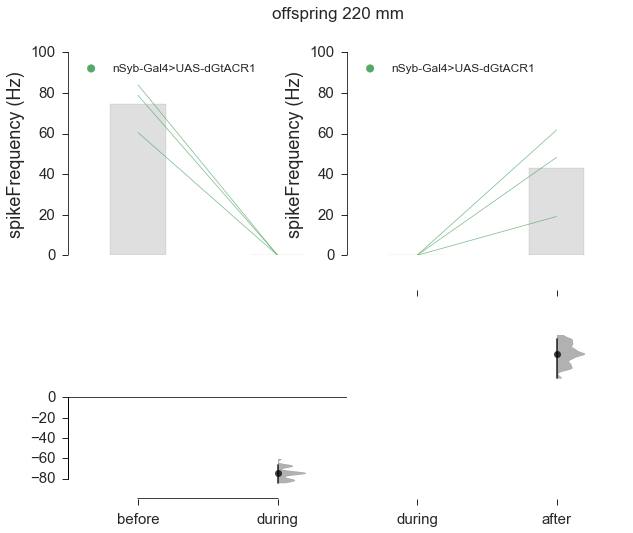

In [24]:
# Make sure you have updated to bootstrapContrast v0.260.
threshold = 2.58 # This is the scaled threshold, in SD of the signal.
writedir = datadir + 'threshold_'+str(threshold)+'_SD/contrastPlots/'

# Create color palette.
myPal = dict( zip( spikes_dropped['genotype'].unique(), 
          sb.color_palette(n_colors = len(spikes_dropped['genotype'].unique()) )
                 )
            )
# Plot 500ms data.
%matplotlib inline
contrastDict500ms = dict()
figureDict500ms = dict()

for illum in spikes_dropped['illumination_mm'].unique():
    for status in spikes_dropped['status'].unique():
        tempdf = spikes_dropped[ (spikes_dropped['status'] == status) & 
                                (spikes_dropped['illumination_mm'] == illum) ]
        
        fig, con = bs.pairedcontrast( tempdf, 
                                     figsize = (10,8),
                                     x = 'epoch', y = 'spikeFrequency (Hz)',
                                     idcol = 'traceNameNumPulse',
                                     floatContrast = False,
                                     summaryBar = True,
                                     pal = myPal,
                                     swarmYlim = (0,100),
                                     contrastYlim = (-100,100),
                                     showAllYAxes = False,
                                     violinWidth = 0.002,
                                     barWidth = 0.002,
                                     beforeAfterSpacer = 0.005,
                                     summaryMarkerSize = 7,
                                     hue = 'genotype',
                                     idx = (('before', 'during'),
                                           ('during', 'after')) )
        # Aesthetic tweaks
        conKey = str(status)+' '+str(illum)+' mm'
        fig.suptitle(conKey, fontsize = 17)
        figureDict500ms[conKey] = fig
        # save the contrast information.
        contrastDict500ms[conKey] = con
        # Save each figure in SUPERHIGHRES png and svg YAS
        for f in ['png', 'svg']:
            fig.savefig(writedir+conKey+'.'+f, format = f, dpi = 500)